In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter


In [6]:
dataset = pd.read_parquet(r'../local_dataset/dataset/merged_full.parquet')
dataset.drop(columns=['lon', 'lat'], inplace=True, errors='ignore')

dataset_numeric_columns = dataset.select_dtypes(include=['number']).columns
dataset_string_columns = dataset.select_dtypes(include=['object']).columns
dataset[dataset_numeric_columns] = dataset[dataset_numeric_columns].fillna(dataset[dataset_numeric_columns].mean())
dataset[dataset_string_columns] = dataset[dataset_string_columns].fillna(dataset[dataset_string_columns].mode().iloc[0])

print(dataset.isnull().sum())

X = dataset.drop('fire', axis=1)
X_string_columns = X.select_dtypes(include=['object']).columns
X[X_string_columns] = OrdinalEncoder().fit_transform(X[X_string_columns])

Y = dataset['fire']

print(X.head())
print(Y.head())

X_train, X_test, Y_train, Y_test = train_test_split(
    X.to_numpy(), Y.to_numpy(),
    test_size=0.2,      # 20% test
    random_state=42,    # for reproducibility
    shuffle=True        # default True
)

fire                      0
log_precip_s1             0
log_precip_s2             0
log_precip_s3             0
log_precip_s4             0
tmax_s1                   0
tmax_s2                   0
tmax_s3                   0
tmax_s4                   0
amplitude_thermique_s1    0
amplitude_thermique_s2    0
amplitude_thermique_s3    0
amplitude_thermique_s4    0
GRIDCODE                  0
log_area_sqm              0
lcc_code_encoded          0
elevation                 0
COARSE                    0
SAND                      0
SILT                      0
CLAY                      0
TEXTURE_USDA              0
TEXTURE_SOTER             0
BULK                      0
REF_BULK                  0
ORG_CARBON                0
PH_WATER                  0
TOTAL_N                   0
CN_RATIO                  0
CEC_SOIL                  0
CEC_CLAY                  0
CEC_EFF                   0
TEB                       0
BSAT                      0
ALUM_SAT                  0
ESP                 

# Sampling Funcitons

In [7]:
def random_sample(X, Y, n_rows=None, n_cols=None, random_state=None):
    """
    Randomly sample rows and columns from numpy features and labels.

    Parameters
    ----------
    X : np.ndarray, shape (n_samples, n_features)
        Feature matrix
    y : np.ndarray, shape (n_samples,)
        Labels
    n_rows : int, optional
        Number of rows to sample. Default: all rows
    n_cols : int, optional
        Number of columns to sample. Default: all columns
    random_state : int, optional
        Seed for reproducibility

    Returns
    -------
    X_sample : np.ndarray, shape (n_rows, n_cols)
    y_sample : np.ndarray, shape (n_rows,)
    row_idx : np.ndarray, indices of sampled rows
    col_idx : np.ndarray, indices of sampled columns
    """
    
    rng = np.random.default_rng(random_state)
    n_total_rows, n_total_cols = X.shape

    row_idx = rng.choice(n_total_rows, size=n_rows, replace=True)
    col_idx = rng.choice(n_total_cols, size=n_cols, replace=False)

    X_sample = X[row_idx[:, None], col_idx]  # shape (n_rows, n_cols)
    y_sample = Y[row_idx]                    # shape (n_rows,)

    return X_sample, y_sample, row_idx, col_idx

# Scartch Random Forest

In [8]:
class DecisionTree:
    def __init__(self, tree, X_train, Y_train, X_test, Y_test):
        self.model = tree
        self.X_train = X_train
        self.Y_train = Y_train
        self.X_test = X_test
        self.Y_test = Y_test

decision_trees_count = 10
random_forest = []

rows_number = X_train.shape[0]
cols_number = int(np.sqrt(X_train.shape[1]))

for i in range(decision_trees_count):
    X_train_sample, Y_train_sample, row_idx, col_idx = random_sample(X_train, Y_train, rows_number, cols_number, i)
    X_test_sample = X_test[:, col_idx]

    tree = DecisionTree(DecisionTreeClassifier(random_state=i), X_train_sample, Y_train_sample, X_test_sample, Y_test)
    random_forest.append(tree)
    tree.model.fit(X_train_sample, Y_train_sample)
    print(f"Trained tree {i+1}/{decision_trees_count}")



Trained tree 1/10
Trained tree 2/10
Trained tree 3/10
Trained tree 4/10
Trained tree 5/10
Trained tree 6/10
Trained tree 7/10
Trained tree 8/10
Trained tree 9/10
Trained tree 10/10


# Scratch Random Forest Testing

(10, 12093) 10 12093
Accuracy : 0.778136111800215
Precision: 0.711395101171459
Recall   : 0.21688311688311687
F1 Score : 0.3324210002488181


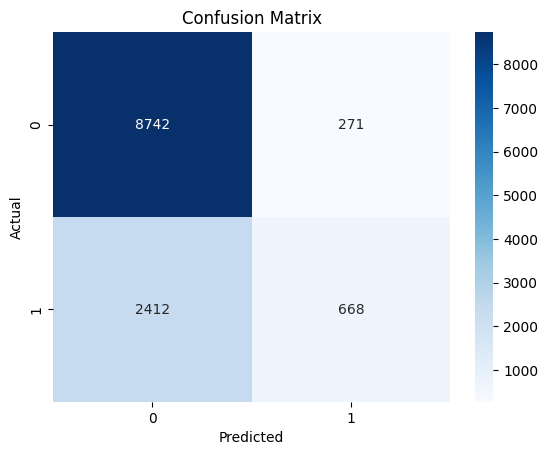

              precision    recall  f1-score   support

           0       0.78      0.97      0.87      9013
           1       0.71      0.22      0.33      3080

    accuracy                           0.78     12093
   macro avg       0.75      0.59      0.60     12093
weighted avg       0.77      0.78      0.73     12093



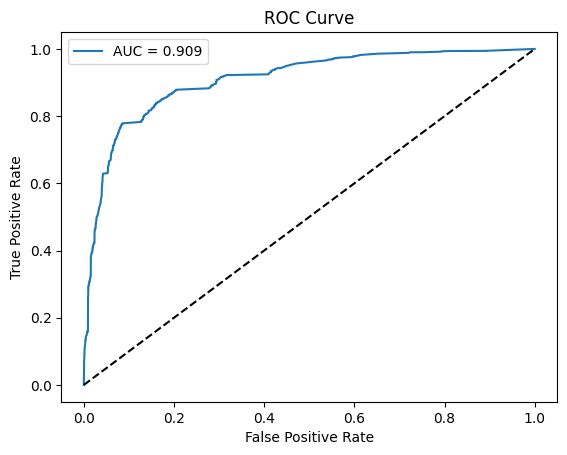

In [ ]:
preds = np.zeros((Y_test.shape[0], decision_trees_count))
probs = np.zeros((decision_trees_count, Y_test.shape[0]))

for i, tree in enumerate(random_forest):
    Y_probs = tree.model.predict_proba(tree.X_test)
    preds[:, i] = Y_probs.argmax(axis=1)
    probs[i, :] = Y_probs[:, 1]

preds = np.array([Counter(preds[i, :]).most_common(1)[0][0] for i in range(preds.shape[0])])

print("Accuracy :", accuracy_score(Y_test, preds))
print("Precision:", precision_score(Y_test, preds, average='binary'))
print("Recall   :", recall_score(Y_test, preds, average='binary'))
print("F1 Score :", f1_score(Y_test, preds, average='binary'))

cm = confusion_matrix(Y_test, preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print(classification_report(Y_test, preds))

fpr, tpr, _ = roc_curve(Y_test, probs.mean(axis=0))
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# SKLearn Random Forest Training

Accuracy : 0.9080459770114943
Precision: 0.8295378432685867
Recall   : 0.8042207792207792
F1 Score : 0.8166831519947247


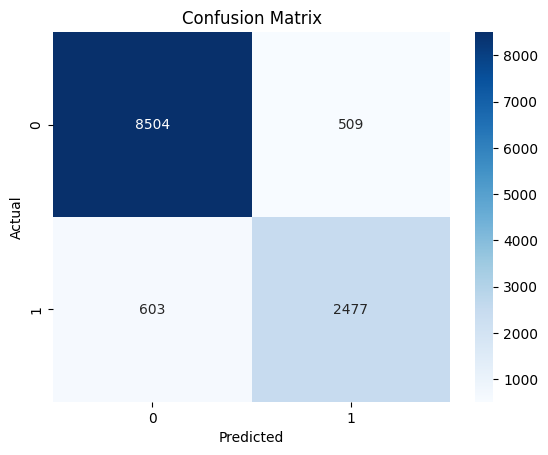

              precision    recall  f1-score   support

           0       0.93      0.94      0.94      9013
           1       0.83      0.80      0.82      3080

    accuracy                           0.91     12093
   macro avg       0.88      0.87      0.88     12093
weighted avg       0.91      0.91      0.91     12093



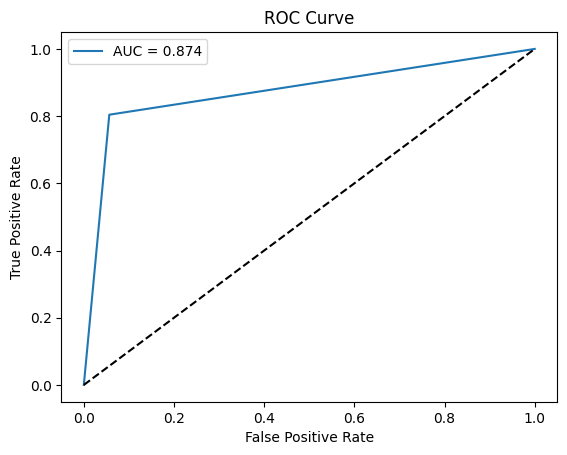

In [11]:
random_forest = RandomForestClassifier(n_estimators=decision_trees_count, random_state=42)
random_forest.fit(X_train, Y_train)

probs = random_forest.predict_proba(X_test)
preds = probs.argmax(axis=1)

print("Accuracy :", accuracy_score(Y_test, preds))
print("Precision:", precision_score(Y_test, preds, average='binary'))
print("Recall   :", recall_score(Y_test, preds, average='binary'))
print("F1 Score :", f1_score(Y_test, preds, average='binary'))

cm = confusion_matrix(Y_test, preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print(classification_report(Y_test, preds))

fpr, tpr, _ = roc_curve(Y_test, preds)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()